<div style="text-align: center;">
   <h1>TD 2 : Analyse du Dataset Titanic avec Techniques Avancéesen Python </h1> 
</div>

## Contexte
Le dataset `Titanic` contient des informations sur les passagers du Titanic, y compris des détails
tels que leur survie, leur classe de billet, leur âge, leur sexe, et bien d'autres. L'objectif de ce
projet est de traiter et d'analyser ces données en utilisant des techniques avancées de
programmation en Python, tout en respectant les bonnes pratiques de développement.

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pydantic import BaseModel, model_validator
from typing import Dict, Any, List
from datetime import datetime
import warnings


# Documentation du Code

Ce script fournit un utilitaire de journalisation (`logging`) et de mesure du temps d'exécution pour les fonctions Python. Il utilise le module `logging` pour enregistrer les temps d'exécution et supprime les avertissements (`warnings`) à l'aide du module `warnings`.

---

## Modules Utilisés
- `warnings` : Pour ignorer les avertissements pendant l'exécution.
- `logging` : Pour enregistrer les informations et les temps d'exécution dans un fichier.
- `time` : Pour mesurer le temps d'exécution des fonctions.

---

## Configuration du Logging
Les logs sont enregistrés dans un fichier nommé `titanic.log` avec le format suivant :

In [2]:
import warnings
import logging
import time

warnings.filterwarnings('ignore')

logging.basicConfig(
    filename='titanic.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        logging.info(f"La fonction {func.__name__} a été exécutée en {execution_time:.4f} secondes")
        return result
    return wrapper

# Modèle de Validation des Données avec Pydantic ✅

La classe `DataValidateModel` est un modèle Pydantic conçu pour valider les données d'un DataFrame pandas. Elle vérifie à la fois les types des colonnes et les plages de valeurs pour s'assurer que les données sont conformes aux attentes.

---

## Classe `DataValidateModel`

### Description
Cette classe permet de valider un DataFrame pandas en vérifiant :
1. Les types de données des colonnes.
2. Les plages de valeurs pour certaines colonnes spécifiques.

### Attributs
- **df** : Un DataFrame pandas à valider.

### Configuration
- `arbitrary_types_allowed = True` : Autorise l'utilisation de types arbitraires (comme un DataFrame pandas) dans le modèle.

---

## Validateurs

### 1. `validate_column_types`
Ce validateur vérifie que les colonnes du DataFrame ont les types de données attendus.

#### Règles de validation
- Vérifie que toutes les colonnes spécifiées dans `expected_types` sont présentes dans le DataFrame.
- Vérifie que le type de chaque colonne correspond au type attendu.

#### Exemple d'erreurs
- Si une colonne est manquante : `"La colonne 'age' est manquante dans le DataFrame"`
- Si le type d'une colonne est incorrect : `"La colonne 'age' devrait être de type float64, mais elle est de type int64"`

### 2. `validate_value_ranges`
Ce validateur vérifie que les valeurs des colonnes respectent les plages attendues.

#### Règles de validation
- **sex** : Doit être soit `'male'`, soit `'female'`.
- **age** : Doit être compris entre `0` et `100`.
- **fare** : Doit être supérieur ou égal à `0`.
- **pclass** : Doit être `1`, `2` ou `3`.

#### Exemple d'erreurs
- Si une valeur est invalide : `"Valeurs invalides dans la colonne 'sex' : ['unknown']"`



In [3]:

# Modèle de validation des données avec Pydantic ✅
class DataValidateModel(BaseModel):
    df: pd.DataFrame
    expected_types: Dict[str, str] = {
        'survived': 'uint8',
        'pclass': 'uint8',
        'sex': 'object',
        'age': 'float32',
        'sibsp': 'uint8',
        'parch': 'uint8',
        'fare': 'float32',
        'embarked': 'object',  
        'class': 'object',     
        'who': 'object',       
        'adult_male': 'bool',
        'deck': 'object',      
        'embark_town': 'object',  
        'alive': 'object',     
        'alone': 'bool'
    }
    
    model_config = {
        "arbitrary_types_allowed": True,
    }

    @model_validator(mode='after')
    def validate_column_types(self):
        expected_types = self.expected_types
        df = self.df
        errors = []
        for field, expected_type in expected_types.items():
            if field not in df.columns:
                errors.append(f"La colonne '{field}' est manquante dans le DataFrame")
            elif not np.issubdtype(df[field].dtype, np.dtype(expected_type)):
                errors.append(f"La colonne '{field}' devrait être de type {expected_type}, mais elle est de type {df[field].dtype}")
        
        if errors:
            logging.error(f"Erreurs de validation des colonnes : {errors}")
            raise ValueError("\n".join(errors))
        
        return self
    
    @model_validator(mode='after')
    def validate_value_ranges(self):
        df = self.df
        errors = []
        
        if 'sex' in df.columns:
            invalid_sex = df[~df['sex'].isin(['male', 'female'])]['sex'].unique()
            if len(invalid_sex) > 0:
                errors.append(f"Valeurs invalides dans la colonne 'sex' : {invalid_sex}")
        
        if 'age' in df.columns:
            invalid_age = df[(df['age'] < 0) | (df['age'] > 100)]['age'].unique()
            if len(invalid_age) > 0:
                errors.append(f"Valeurs invalides dans la colonne 'age' : {invalid_age}")
        
        if 'fare' in df.columns:
            invalid_fare = df[df['fare'] < 0]['fare'].unique()
            if len(invalid_fare) > 0:
                errors.append(f"Valeurs invalides dans la colonne 'fare' : {invalid_fare}")
        
        if 'pclass' in df.columns:
            invalid_pclass = df[~df['pclass'].isin([1, 2, 3])]['pclass'].unique()
            if len(invalid_pclass) > 0:
                errors.append(f"Valeurs invalides dans la colonne 'pclass' : {invalid_pclass}")

        if errors:
            logging.error(f"Erreurs de validation des valeurs : {errors}")
            raise ValueError("\n".join(errors))
        
        return self



# Documentation de la Classe `DataAnalyzer`

La classe `DataAnalyzer` permet de charger, nettoyer, analyser et visualiser des données, en particulier pour un dataset de type Titanic. Elle utilise des fonctionnalités de journalisation (`logging`) et de mesure du temps d'exécution (`@timer`) pour suivre les étapes de traitement des données.

---

## Rôle de `__slots__`
- `__slots__` est utilisé pour optimiser la mémoire en restreignant les attributs autorisés dans la classe.
- Les attributs autorisés sont : `filepath`, `raw_data`,`d_types`, et `cleaned_data`.
- Cela empêche la création dynamique de nouveaux attributs, ce qui réduit l'utilisation de la mémoire.

---

## Étapes Principales

### 1. **Initialisation**
- La classe est initialisée avec le chemin du fichier CSV contenant les données.
- Les attributs `raw_data` (données brutes) et `cleaned_data` (données nettoyées) sont initialisés à `None`.

---

### 2. **Chargement des Données (`load_data`)**
- Charge les données depuis le fichier CSV spécifié.
- Valide les données en utilisant la classe `DataValidateModel`.
- Enregistre un message de succès ou d'erreur dans les logs.

---

### 3. **Nettoyage des Données (`clean_data`)**
- Supprime les valeurs manquantes dans les colonnes critiques (`age`, `embarked`, `fare`).
- Supprime les outliers dans les colonnes numériques (`age`, `fare`) en utilisant la méthode IQR.
- Valide les données nettoyées avec `DataValidateModel`.

---

### 4. **Calcul des Statistiques (`compute_statistics`)**
- Calcule des statistiques descriptives sur les données nettoyées, telles que :
  - Taux de survie global.
  - Âge moyen des passagers.
  - Prix médian du billet.
  - Nombre de passagers par sexe et classe.
  - Taux de survie par sexe et classe.

---

### 5. **Génération de Visualisations (`generate_visualizations`)**
- Génère des graphiques à partir des données nettoyées, tels que :
  - Heatmap de corrélation.
  - Taux de survie par classe.
  - Distribution des âges par sexe.
  - Relation entre âge, prix du billet et survie.
- Enregistre les visualisations dans un dossier spécifié.

---

## Méthodes Internes

### `_remove_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame`
- Supprime les outliers d'une colonne spécifique en utilisant la méthode IQR.
- Enregistre les bornes des outliers et le nombre d'outliers supprimés dans les logs.

---

## Journalisation
- Toutes les étapes sont enregistrées dans un fichier de log (`titanic.log`) pour un suivi facile des opérations.

---

## Remarques
- Assurez-vous que le fichier CSV est correctement formaté.
- Le dossier de sortie pour les visualisations doit être accessible en écriture.

In [4]:
class DataAnalyzer:
    __slots__ = ['filepath', 'raw_data', 'cleaned_data' , 'd_types']
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.raw_data = None
        self.cleaned_data = None
        self.d_types: Dict[str, str] = {
                'survived': 'uint8',
                'pclass': 'uint8',
                'sex': 'object',
                'age': 'float32',
                'sibsp': 'uint8',
                'parch': 'uint8',
                'fare': 'float32',
                'embarked': 'object',  
                'class': 'object',     
                'who': 'object',       
                'adult_male': 'bool',
                'deck': 'object',      
                'embark_town': 'object',  
                'alive': 'object',     
                'alone': 'bool'
        }
        logging.info(f"DataAnalyzer initialisé avec le fichier : {filepath}")
    
    @timer
    def load_data(self) -> pd.DataFrame:
        try:
            self.raw_data = pd.read_csv(self.filepath,dtype=self.d_types)
            logging.info(f"Données chargées avec succès depuis {self.filepath} : {len(self.raw_data)} lignes")
            
            # Validation des données ✅
            DataValidateModel(df=self.raw_data)
            logging.info("Validation des données réussie")
            
            return self.raw_data
        except Exception as e:
            logging.error(f"Erreur lors du chargement ou de la validation des données : {e}")
            raise
    
    @timer
    def clean_data(self) -> pd.DataFrame:
        if self.raw_data is None:
            logging.error("Impossible de nettoyer les données : Les données brutes ne sont pas chargées")
            raise ValueError("Les données brutes ne sont pas chargées. Appelez load_data() d'abord.")
        
        cleaned_df = self.raw_data.copy()
        initial_rows = len(cleaned_df)
        
        # 1. Suppression des valeurs manquantes dans les colonnes critiques 🧹
        critical_columns = ['age', 'embarked', 'fare']
        cleaned_df = cleaned_df.dropna(subset=critical_columns)
        after_na_drop = len(cleaned_df)
        logging.info(f"{initial_rows - after_na_drop} lignes avec des valeurs manquantes supprimées dans les colonnes critiques")
        
        # 2. Détection et suppression des outliers (méthode IQR) 📊
        numerical_columns = ['age', 'fare']
        for column in numerical_columns:
            cleaned_df = self._remove_outliers(cleaned_df, column)
        
        after_outlier_removal = len(cleaned_df)
        logging.info(f"{after_na_drop - after_outlier_removal} lignes avec des outliers supprimées")
        
        # Validation des données nettoyées ✅
        try:
            DataValidateModel(df=cleaned_df)
            logging.info("Validation des données nettoyées réussie")
            self.cleaned_data = cleaned_df
            return self.cleaned_data
        except Exception as e:
            logging.error(f"Erreur lors de la validation des données nettoyées : {e}")
            raise
    
    def _remove_outliers(self, df: pd.DataFrame, column: str) -> pd.DataFrame:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        logging.info(f"Bornes des outliers pour {column} : inférieure={lower_bound:.2f}, supérieure={upper_bound:.2f}")
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if not outliers.empty:
            logging.info(f"{len(outliers)} outliers trouvés dans la colonne {column}")
        
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    @timer
    def compute_statistics(self) -> Dict[str, Any]:
        if self.cleaned_data is None:
            logging.error("Impossible de calculer les statistiques : Les données nettoyées ne sont pas disponibles")
            raise ValueError("Les données nettoyées ne sont pas disponibles. Appelez clean_data() d'abord.")
        
        stats = {}
        
        # Taux de survie global 📈
        stats['survival_rate'] = self.cleaned_data['survived'].mean() * 100
        
        # Âge moyen des passagers 🎂
        stats['mean_age'] = self.cleaned_data['age'].mean()
        
        # Prix médian du billet 💰
        stats['median_fare'] = self.cleaned_data['fare'].median()
        
        # Statistiques supplémentaires 📊
        stats['passengers_count'] = len(self.cleaned_data)
        stats['male_count'] = len(self.cleaned_data[self.cleaned_data['sex'] == 'male'])
        stats['female_count'] = len(self.cleaned_data[self.cleaned_data['sex'] == 'female'])
        stats['male_survival_rate'] = self.cleaned_data[self.cleaned_data['sex'] == 'male']['survived'].mean() * 100
        stats['female_survival_rate'] = self.cleaned_data[self.cleaned_data['sex'] == 'female']['survived'].mean() * 100
        
        # Statistiques par classe 🎫
        for pclass in [1, 2, 3]:
            stats[f'class_{pclass}_count'] = len(self.cleaned_data[self.cleaned_data['pclass'] == pclass])
            stats[f'class_{pclass}_survival_rate'] = self.cleaned_data[self.cleaned_data['pclass'] == pclass]['survived'].mean() * 100
        
        logging.info("Statistiques calculées avec succès")
        for key, value in stats.items():
            if isinstance(value, (int, float)):
                logging.info(f"Statistique : {key} = {value:.2f}")
            else:
                logging.info(f"Statistique : {key} = {value}")
        
        return stats
    
    def generate_visualizations(self, output_dir: str = "./") -> List[str]:
        if self.cleaned_data is None:
            logging.error("Impossible de générer les visualisations : Les données nettoyées ne sont pas disponibles")
            raise ValueError("Les données nettoyées ne sont pas disponibles. Appelez clean_data() d'abord.")
        
        file_paths = []
        
        # Créer une figure avec des sous-graphiques
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Visualisations du Dataset Titanic', fontsize=16)
        axes = axes.flatten()  
        
        # 1. Heatmap de corrélation 🔥
        correlation_matrix = self.cleaned_data.select_dtypes(include=['number']).corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[0])
        axes[0].set_title('Matrice de Corrélation des Variables Numériques')
        
        correlation_file = f"{output_dir}/correlation_heatmap.png"
        file_paths.append(correlation_file)
        logging.info(f"Heatmap de corrélation enregistrée sous {correlation_file}")
        
        # 2. Taux de survie par classe 📊
        survival_by_class = self.cleaned_data.groupby('pclass')['survived'].mean() * 100
        survival_by_class.plot(kind='bar', color='skyblue', ax=axes[1])
        axes[1].set_title('Taux de Survie par Classe')
        axes[1].set_xlabel('Classe')
        axes[1].set_ylabel('Taux de Survie (%)')
        axes[1].set_xticks(range(len(survival_by_class)))
        axes[1].set_xticklabels(survival_by_class.index, rotation=0)
        
        # Ajouter les valeurs sur les barres 📝
        for i, v in enumerate(survival_by_class):
            axes[1].text(i, v + 1, f"{v:.1f}%", ha='center')
        
        survival_file = f"{output_dir}/survival_by_class.png"
        file_paths.append(survival_file)
        logging.info(f"Graphique de survie par classe enregistré sous {survival_file}")

        
        # Ajuster la mise en page et enregistrer la figure
        combined_file = f"{output_dir}/all_visualizations.png"
        plt.savefig(combined_file)
        plt.show()
        plt.close()
        
        # Ajouter le fichier combiné à la liste des chemins de fichiers
        file_paths.append(combined_file)
        logging.info(f"Toutes les visualisations enregistrées sous {combined_file}")
        
        return file_paths

# Fonction Principale pour Exécuter l'Analyse 🚀

La fonction `main()` orchestre l'ensemble du processus d'analyse des données, en utilisant la classe `DataAnalyzer`. Elle charge les données, les nettoie, calcule des statistiques, génère des visualisations et gère les erreurs.


In [5]:
# Fonction principale pour exécuter l'analyse 🚀
def main():
    try:
        # Chemin du fichier Titanic 🚢
        filepath = "data.csv"
        
        # Initialisation de l'analyseur 🔍
        analyzer = DataAnalyzer(filepath)
        
        # Chargement des données 📂
        raw_data = analyzer.load_data()
        print(f"Données brutes chargées: {len(raw_data)} lignes")
        
        # Nettoyage des données 🧹
        cleaned_data = analyzer.clean_data()
        print(f"Données nettoyées: {len(cleaned_data)} lignes")
        
        # Calcul des statistiques 📊
        stats = analyzer.compute_statistics()
        print("\nStatistiques clés:")
        for key, value in stats.items():
            if isinstance(value, (int, float)):
                print(f"- {key}: {value:.2f}")
            else:
                print(f"- {key}: {value}")
        
        # Génération des visualisations 🎨
        visualization_files = analyzer.generate_visualizations()
        print("\nVisualisations générées:")
        for file in visualization_files:
            print(f"- {file}")
        
        
        print("\nAnalyse terminée avec succès! ✅")
        
    except Exception as e:
        logging.error(f"Erreur lors de l'exécution principale : {e}", exc_info=True)
        print(f"Erreur lors de l'exécution: {e} ❌")


Données brutes chargées: 891 lignes
Données nettoyées: 610 lignes

Statistiques clés:
- survival_rate: 35.90
- mean_age: 28.427459716796875
- median_fare: 13.0
- passengers_count: 610.00
- male_count: 407.00
- female_count: 203.00
- male_survival_rate: 19.16
- female_survival_rate: 69.46
- class_1_count: 91.00
- class_1_survival_rate: 56.04
- class_2_count: 166.00
- class_2_survival_rate: 50.00
- class_3_count: 353.00
- class_3_survival_rate: 24.08


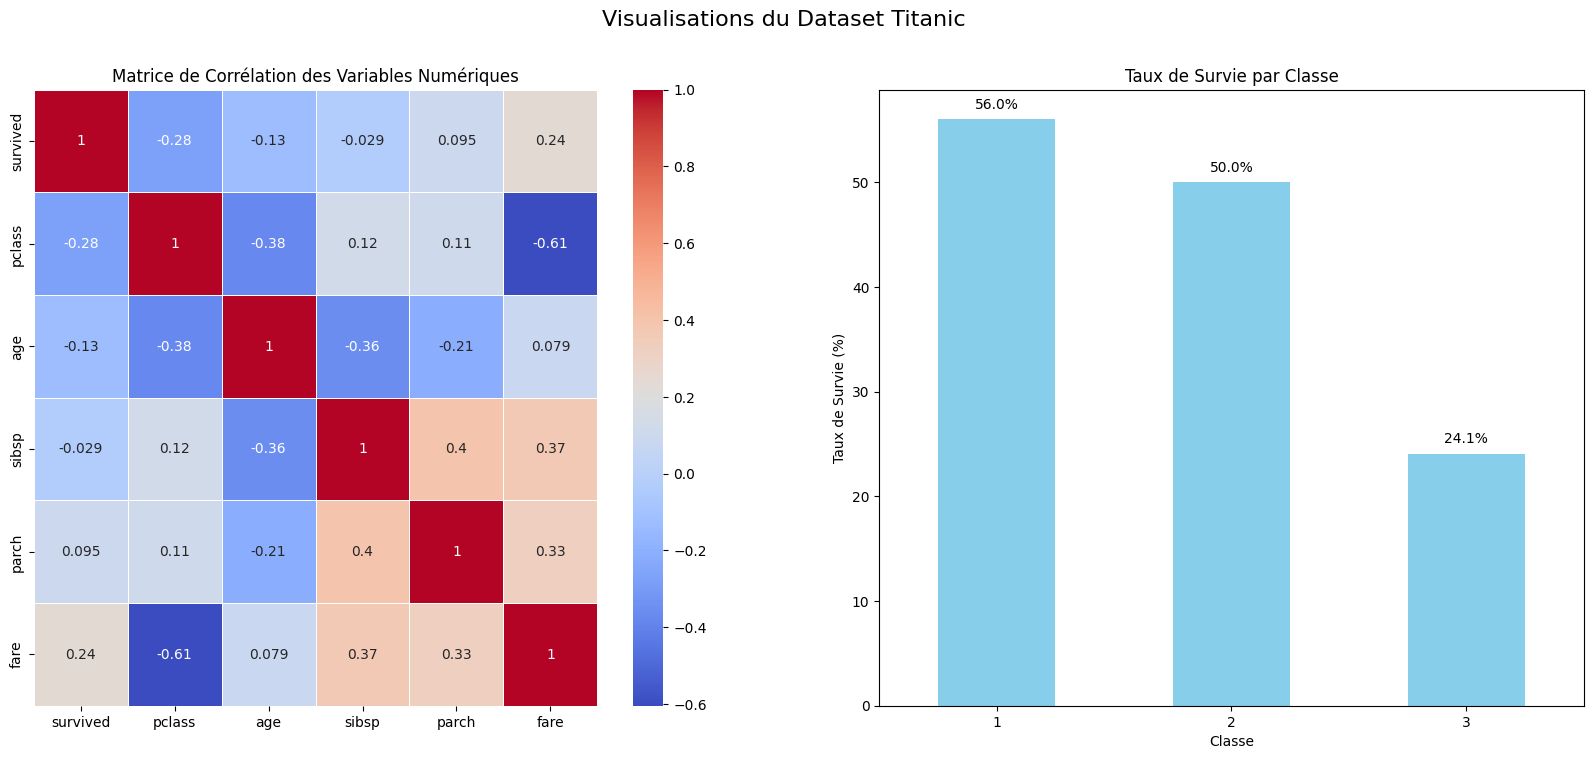


Visualisations générées:
- .//correlation_heatmap.png
- .//survival_by_class.png
- .//all_visualizations.png

Analyse terminée avec succès! ✅


In [6]:
# Point d'entrée du programme 🏁
if __name__ == "__main__":
    main()


## Résumé
Ce rapport présente l'analyse des données du Titanic après nettoyage et validation.

## Statistiques Clés
- **Nombre total de passagers (après nettoyage)**: `610`
- **Taux de survie global**: `35.90`
- **Âge moyen des passagers**: `28.43`
- **Prix médian du billet**: `13$`

## Analyse par Genre
- **Nombre d'hommes**: `40.70%`/`61%`
- **Nombre de femmes**: `20.30%`/`61%`
- **Taux de survie des hommes**: `19.16%`
- **Taux de survie des femmes**: `69.46%`

## Analyse par Classe
- **Classe 1**: `91.00` passagers, taux de survie de `56.04%`
- **Classe 2**: `166.00` passagers, taux de survie de `50.00%`
- **Classe 3**: `353.00` passagers, taux de survie de `24.08`

## Observations
1. Les femmes ont un taux de survie significativement plus élevé que les hommes.
2. Les passagers de première classe ont un meilleur taux de survie que ceux des autres classes.
3. L'âge a une influence sur la survie, avec les enfants ayant plus de chances de survivre.

## Visualisations
Les visualisations suivantes ont été générées:
1. Matrice de corrélation des variables numériques
2. Taux de survie par classe
3. Distribution des âges par sexe
4. Relation entre l'âge, le prix du billet et la survie
## Méthodologie
1. Chargement des données à partir du fichier CSV
2. Validation des types et des plages de valeurs
3. Nettoyage des données (valeurs manquantes et outliers)
4. Calcul des statistiques descriptives
5. Génération des visualisations

## Problèmes de Validation des Données avec Pydantic
Lors de la validation des données avec Pydantic, plusieurs problèmes peuvent survenir, en particulier lorsque vous travaillez avec des données provenant de sources externes (comme un fichier CSV). Voici une section détaillée sur les problèmes courants:
1. Valeurs Manquantes:
    - `Problème `: Les colonnes peuvent contenir des valeurs manquantes (NaN), ce qui peut entraîner des erreurs de validation.
2. Outliers :
    - `Problème` : Les valeurs aberrantes (outliers) peuvent fausser les analyses et entraîner des erreurs de validation.
3. Validation de Catégories : 
    - `Problème` : Les colonnes catégorielles peuvent contenir des valeurs non autorisées.
4. Erreurs de Validation Pydantic : 
    - `Problème` : Pydantic lève des exceptions (ValidationError) lorsque les données ne respectent pas le modèle.

## Contenu d'un Fichier Log

```plaintext
2025-03-04 13:19:13,818 - INFO - DataAnalyzer initialisé avec le fichier : data.csv
2025-03-04 13:19:13,830 - INFO - Données chargées avec succès depuis data.csv : 891 lignes
2025-03-04 13:19:13,846 - INFO - Validation des données réussie
2025-03-04 13:19:13,846 - INFO - La fonction load_data a exécuté en 0.0278 secondes
2025-03-04 13:19:13,851 - INFO - 179 lignes avec des valeurs manquantes supprimées dans les colonnes critiques
2025-03-04 13:19:13,853 - INFO - Bornes des outliers pour age : inférieure=7.00, supérieure=65.00
2025-03-04 13:19:13,854 - INFO - 8 outliers trouvés dans la colonne age
2025-03-04 13:19:13,858 - INFO - Bornes des outliers pour fare : inférieure=-28.81, supérieure=69.49
2025-03-04 13:19:13,859 - INFO - 94 outliers trouvés dans la colonne fare
2025-03-04 13:19:13,860 - INFO - 102 lignes avec des outliers supprimées
2025-03-04 13:19:13,865 - INFO - Validation des données nettoyées réussie
2025-03-04 13:19:13,866 - INFO - La fonction clean_data a exécuté en 0.0183 secondes
2025-03-04 13:19:13,872 - INFO - Statistiques calculées avec succès
2025-03-04 13:19:13,872 - INFO - Statistique : survival_rate = 35.90
2025-03-04 13:19:13,872 - INFO - Statistique : mean_age = 28.427459716796875
2025-03-04 13:19:13,872 - INFO - Statistique : median_fare = 13.0
2025-03-04 13:19:13,872 - INFO - Statistique : passengers_count = 610.00
2025-03-04 13:19:13,872 - INFO - Statistique : male_count = 407.00
2025-03-04 13:19:13,872 - INFO - Statistique : female_count = 203.00
2025-03-04 13:19:13,872 - INFO - Statistique : male_survival_rate = 19.16
2025-03-04 13:19:13,873 - INFO - Statistique : female_survival_rate = 69.48
2025-03-04 13:19:13,873 - INFO - Statistique : class_1_count = 91.00
2025-03-04 13:19:13,873 - INFO - Statistique : class_1_survival_rate = 56.04
2025-03-04 13:19:13,873 - INFO - Statistique : class_2_count = 166.00
2025-03-04 13:19:13,873 - INFO - Statistique : class_2_survival_rate = 50.00
2025-03-04 13:19:13,873 - INFO - Statistique : class_3_count = 353.00
2025-03-04 13:19:13,873 - INFO - Statistique : class_3_survival_rate = 24.08
2025-03-04 13:19:13,873 - INFO - La fonction compute_statistics a exécuté en 0.0062 secondes
2025-03-04 13:19:14,023 - INFO - Heatmap de corrélation enregistrée sous .//correlation_heatmap.png
2025-03-04 13:19:14,033 - INFO - Graphique de survie par classe enregistrée sous .//survival_by_class.png
2025-03-04 13:19:14,479 - INFO - Toutes les visualisations enregistrées sous .//all_visualizations.png



<div style="text-align: center;">
   <h2>Mohamed BELANNAB </h2>
</div>